In [ ]:
import seisbench.data as sbd
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.utils.class_weight import compute_class_weight

In [4]:
dataset = sbd.STEAD()
print(len(dataset))

2026-02-26 12:44:43,178 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


1265657


In [ ]:
label_map = {"noise": 0, "earthquake_local": 1}

dataset.metadata["label"] = dataset.metadata["trace_category"].map(label_map)

In [6]:
train_indices = dataset.metadata[dataset.metadata["split"] == "train"].index
dev_indices = dataset.metadata[dataset.metadata["split"] == "dev"].index

In [9]:
class SteadTorchDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]

        waveform = self.dataset.get_waveforms([real_idx])[0]
        label = dataset.metadata.iloc[real_idx]["label"]

        waveform = torch.tensor(waveform, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return waveform, label

In [11]:
train_dataset = SteadTorchDataset(dataset, train_indices)
dev_dataset = SteadTorchDataset(dataset, dev_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False, num_workers=4)

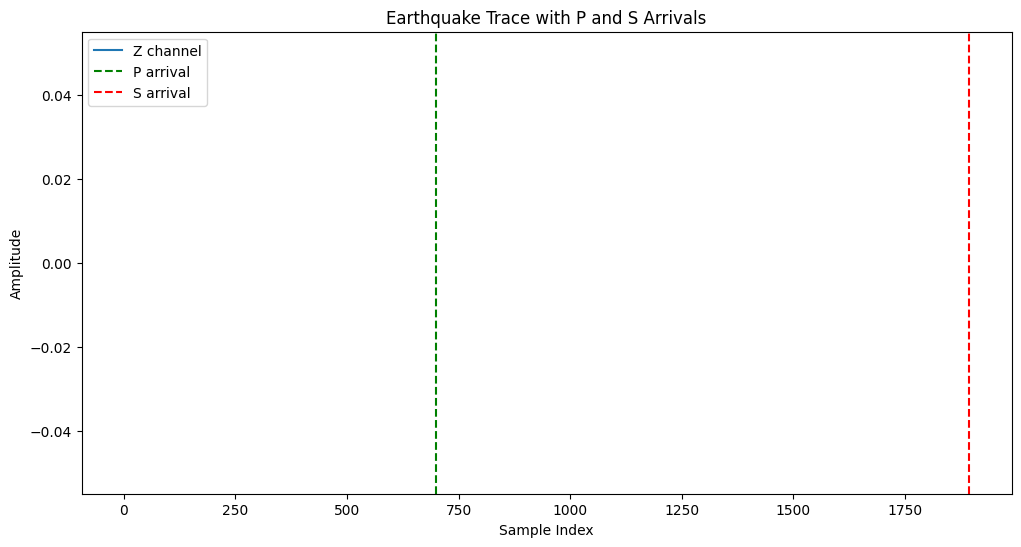

In [ ]:
import matplotlib.pyplot as plt

wave = waveform[0]  # remove batch dimension

p_sample = int(metadata["trace_p_arrival_sample"])
s_sample = int(metadata["trace_s_arrival_sample"])

plt.figure(figsize=(12,6))

plt.plot(wave[0], label="Z channel")

plt.axvline(p_sample, color='g', linestyle='--', label="P arrival")
plt.axvline(s_sample, color='r', linestyle='--', label="S arrival")

plt.legend()
plt.title("Earthquake Trace with P and S Arrivals")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [13]:
print(torch.cuda.is_available())

True


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [16]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        self.conv1 = nn.Conv1d(3, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(32)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(64)

        self.pool = nn.MaxPool1d(4)

        self.fc1 = nn.Linear(64 * (6000 // 4 // 4 // 4), 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [17]:
model = BaselineCNN().to(device)

In [20]:
labels = dataset.metadata.loc[train_indices]["label"].values
classes = np.unique(labels)

weights = compute_class_weight("balanced", classes=classes, y=labels)

print(weights)

[2.68781324 0.61426935]


In [21]:
pos_weight = torch.tensor([weights[0] / weights[1]]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for x, y in loader:
        x = x.to(device)
        y = y.unsqueeze(1).to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [24]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.unsqueeze(1).to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == y).sum().item()
            total += y.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy

In [25]:
num_epochs = 5

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, dev_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print("-" * 30)

Epoch 1
Train Loss: 0.2029
Val Loss: 0.5500
Val Accuracy: 0.9554
------------------------------
Epoch 2
Train Loss: 0.1017
Val Loss: 0.4582
Val Accuracy: 0.9702
------------------------------
Epoch 3
Train Loss: 0.0801
Val Loss: 3.0739
Val Accuracy: 0.9471
------------------------------
Epoch 4
Train Loss: 0.0699
Val Loss: 0.4530
Val Accuracy: 0.9747
------------------------------
Epoch 5
Train Loss: 0.0654
Val Loss: 3.9700
Val Accuracy: 0.9924
------------------------------


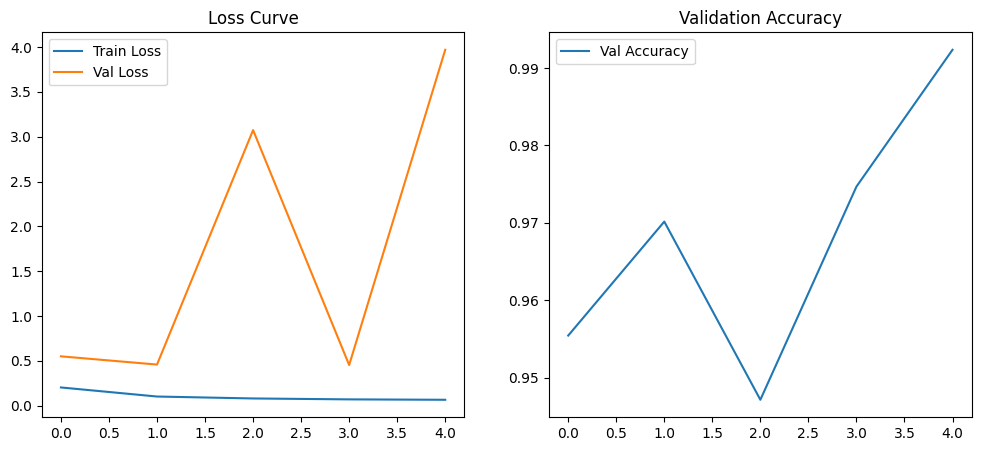

In [26]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in dev_loader:
        x = x.to(device)
        outputs = model(x)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).cpu().numpy()

        all_preds.extend(preds.flatten())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds))

Confusion Matrix:
 [[11433   340]
 [  143 51367]]

Classification Report:

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     11773
         1.0       0.99      1.00      1.00     51510

    accuracy                           0.99     63283
   macro avg       0.99      0.98      0.99     63283
weighted avg       0.99      0.99      0.99     63283



In [28]:
from sklearn.metrics import roc_curve, auc


all_probs = []

model.eval()
with torch.no_grad():
    for x, y in dev_loader:
        x = x.to(device)
        outputs = model(x)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs.flatten())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

AUC: 0.9986142517050233


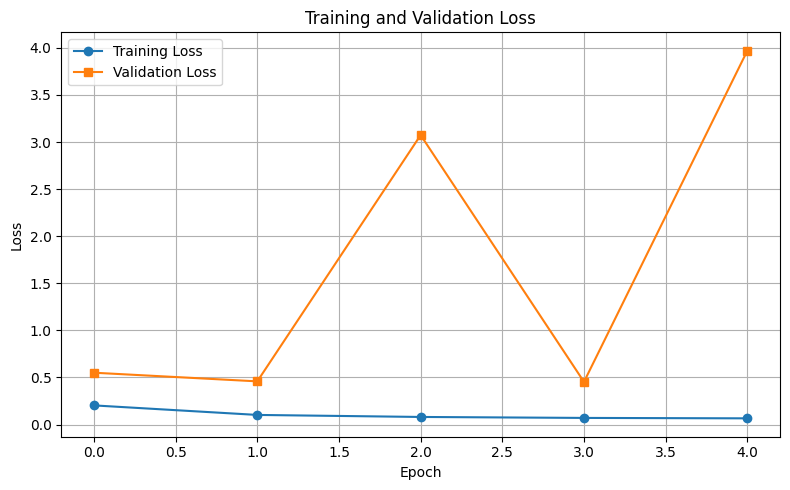

In [29]:

plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(val_losses, marker='s', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("baseline_loss_curve.png", dpi=300)
plt.show()

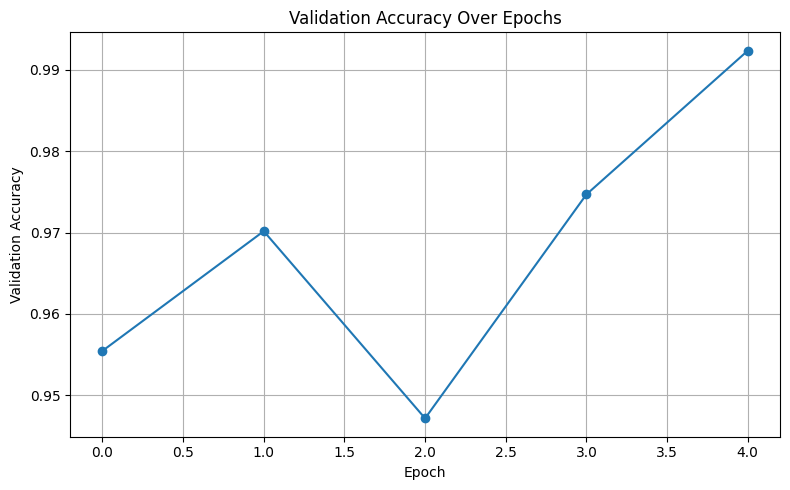

In [30]:
plt.figure(figsize=(8,5))
plt.plot(val_accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.savefig("baseline_accuracy_curve.png", dpi=300)
plt.show()

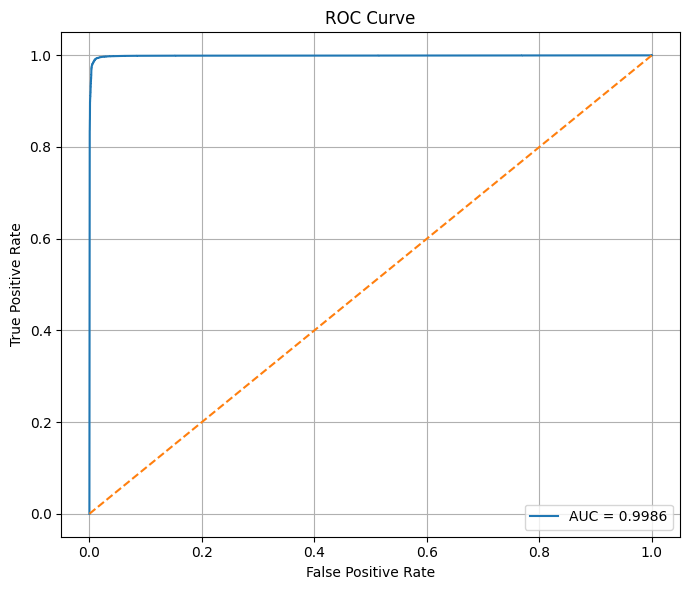

AUC: 0.9986142517050233


In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("baseline_roc_curve.png", dpi=300)
plt.show()

print("AUC:", roc_auc)

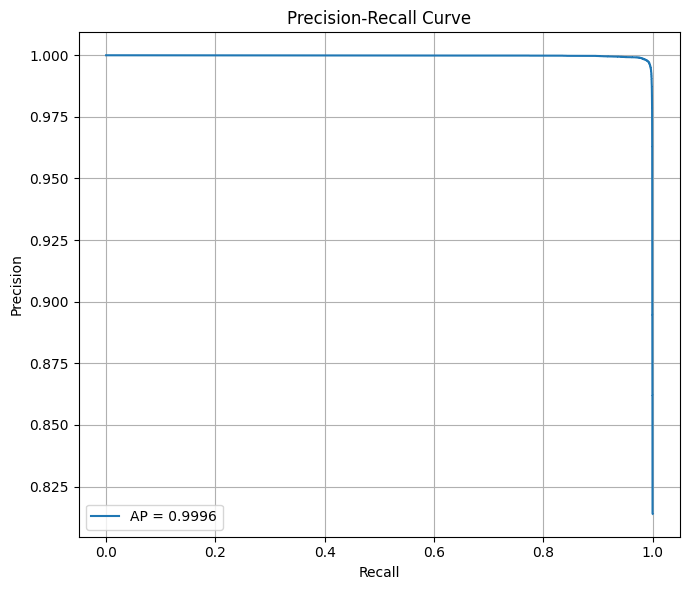

Average Precision: 0.9996428957659146


In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
ap_score = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, label=f"AP = {ap_score:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("baseline_pr_curve.png", dpi=300)
plt.show()

print("Average Precision:", ap_score)

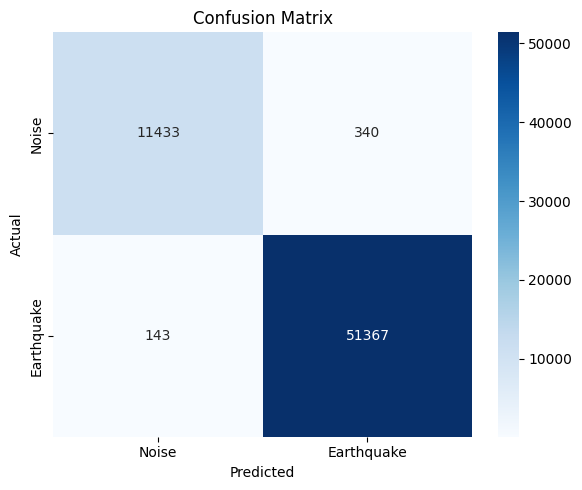

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Noise", "Earthquake"],
            yticklabels=["Noise", "Earthquake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("baseline_confusion_matrix.png", dpi=300)
plt.show()